# Evaluate Geolocation Predictions of Osv5M Model
This notebook evaluates the geolocation predictions of the Osv5M model trained on the CrossLocate (Uniform) dataset using geodesic distance and plots a recall curve.

In [77]:
# Imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import matplotlib.ticker as ticker
import os
from math import radians, sin, cos, sqrt, atan2

In [78]:

def evaluate_geolocation(df_gt, df_pred):
    df_pred.rename(columns={"image": "image_pred"}, inplace=True) 

    df_pred['image_clean'] = (
        df_pred['image_pred']
        .str.replace(r'\.[^.]+$', '', regex=True)
        .str.strip()
    )

    df_gt['image'] = df_gt['image'].str.strip()

    df_pred['pred_lat_deg'] = df_pred['latitude_radians'] * (180.0 / math.pi)
    df_pred['pred_lon_deg'] = df_pred['longitude_radians'] * (180.0 / math.pi)

    df_merged = pd.merge(
        df_gt,
        df_pred,
        left_on='image',        # ground truth
        right_on='image_clean'  # predictions
    )

    distances = []
    for idx, row in df_merged.iterrows():
        gt_coords = (row['latitude'], row['longitude'])             # degrees
        pred_coords = (row['pred_lat_deg'], row['pred_lon_deg'])    # degrees
        dist_m = geodesic(gt_coords, pred_coords).meters
        distances.append(dist_m)

    distances = np.array(distances)

    print("\nDistance stats:")
    if len(distances) > 0:
        print(f"  Min: {distances.min():.2f} m")
        print(f"  Max: {distances.max():.2f} m")
        print(f"  Mean: {distances.mean():.2f} m")
        print(f"  Median: {np.median(distances):.2f} m")
    else:
        print("  No distances computed (0 rows).")

    return distances

In [79]:
def plot_recall_curve(distances):
    if len(distances) == 0:
        print("No distances to plot.")
        return

    thresholds = np.linspace(0, 10000, 101) 
    recalls = [np.mean(distances <= t) for t in thresholds]

    # Plot the recall vs distance curve
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, recalls, label="Osv5M model", color="magenta", linewidth=2)
    plt.axvline(x=1000, linestyle="dotted", label="1000m distance", color="gray")

    plt.xlabel("Distance [m]")
    plt.ylabel("Recall")
    plt.title("Localization (Uniform dataset)")
    plt.ylim(-0.05, 1)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    current_ticks = plt.gca().get_yticks()
    new_ticks = [t for t in current_ticks if t > -0.01 and t < 1]
    plt.gca().set_yticks(new_ticks)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [80]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [81]:
def compute_distances(gt_df, pred_df):
    distances = []
    for _, row in gt_df.iterrows():
        image = row['image']
        pred_row = pred_df[pred_df['image'].str.strip() == image.strip()]
        if not pred_row.empty:
            lat_gt, lon_gt = row['latitude'], row['longitude']
            lat_pred = np.degrees(pred_row.iloc[0]['latitude_radians'])
            lon_pred = np.degrees(pred_row.iloc[0]['longitude_radians'])
            d = haversine_distance(lat_gt, lon_gt, lat_pred, lon_pred)
            distances.append(d)
    return distances

In [82]:
def plot_recall_curve_new(distances_list, labels, max_dist=10000, step=100):
    thresholds = np.arange(0, max_dist + step, step)
    for distances, label in zip(distances_list, labels):
        recall = [np.mean(np.array(distances) <= t) for t in thresholds]
        plt.plot(thresholds, recall, label=label)

    plt.axvline(x=1000, color='black', linestyle=':', label='1000m distance')
    plt.xlabel("Distance error (m)")
    plt.ylabel("Recall")
    plt.title("Localization (Uniform dataset)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Simple regression training

In [97]:
gt_df = pd.read_csv("../../data/gt/datasetInfoClean.csv")
pred_before = pd.read_csv("../../data/results/baseline/geolocations_uniform.csv")
pred_new_frozen = pd.read_csv("../../data/results/new_head_freeze/finetuned_predictions9.csv")
pred_new_full = pd.read_csv("../../data/results/new_head_full/finetuned_predictions9.csv")
pred_origianl_frozen = pd.read_csv("../../data/results/original_head_frozen/finetuned_predictions9.csv")
pred_origianl_full = pd.read_csv("../../data/results/original_head_full/finetuned_predictions9.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/results/original_head_frozen/finetuned_predictions0.csv'

In [84]:
# Normalize predicted names (remove extension)
pred_before["image"] = pred_before["image"].apply(lambda x: os.path.splitext(x)[0])
pred_new_frozen["image"] = pred_new_frozen["image"].apply(lambda x: os.path.splitext(x)[0])
pred_new_full["image"] = pred_new_full["image"].apply(lambda x: os.path.splitext(x)[0])
pred_original_frozen["image"] = pred_original_frozen["image"].apply(lambda x: os.path.splitext(x)[0])
pred_original_full["image"] = pred_original_full["image"].apply(lambda x: os.path.splitext(x)[0])

# Match with GT
gt_df["image"] = gt_df["image"].astype(str).str.strip()

# Restrict GT and pred_before to images that exist in pred_after
valid_images = set(pred_new_full["image"])
gt_df = gt_df[gt_df["image"].isin(valid_images)].copy()
pred_before = pred_before[pred_before["image"].isin(valid_images)].copy()

dist_before = compute_distances(gt_df, pred_before)
dist_new_full = compute_distances(gt_df, pred_new_full)
dist_new_frozen = compute_distances(gt_df, pred_new_frozen)
dist_original_full = compute_distances(gt_df, pred_original_full)
dist_original_frozen = compute_distances(gt_df, pred_original_frozen)


def print_recall_at_thresholds(distances, label, thresholds=[1000, 25000, 200000, 750000]):
    print(f"\nRecall for {label}:")
    distances = np.array(distances)
    for t in thresholds:
        r = np.mean(distances <= t)
        print(f"  Recall @ {t/1000:.0f} km: {r:.3f}")

print_recall_at_thresholds(dist_before, "Before")


Recall for Before:
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.047
  Recall @ 200 km: 0.793
  Recall @ 750 km: 0.944


In [85]:
print_recall_at_thresholds(dist_new_frozen, "New (frozen)")
print_recall_at_thresholds(dist_new_full, "New (full)")


Recall for New (frozen):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.009
  Recall @ 200 km: 0.509
  Recall @ 750 km: 0.993

Recall for New (full):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.078
  Recall @ 200 km: 0.841
  Recall @ 750 km: 1.000


In [86]:
print_recall_at_thresholds(dist_original_frozen, "Original (frozen)")
print_recall_at_thresholds(dist_original_full, "Original (full)")


Recall for Original (frozen):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.044
  Recall @ 200 km: 0.790
  Recall @ 750 km: 0.942

Recall for Original (full):
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.010
  Recall @ 200 km: 0.228
  Recall @ 750 km: 0.444


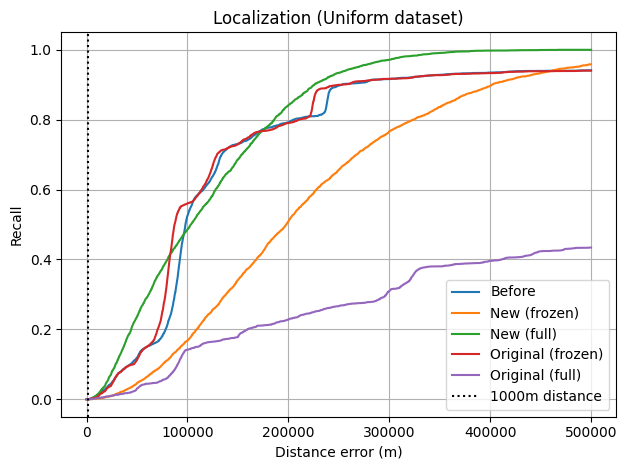

In [87]:
plot_recall_curve_new([dist_before, dist_new_frozen, dist_new_full, dist_original_frozen, dist_original_full], ["Before", "New (frozen)", "New (full)", "Original (frozen)", "Original (full)"], max_dist=500000) 

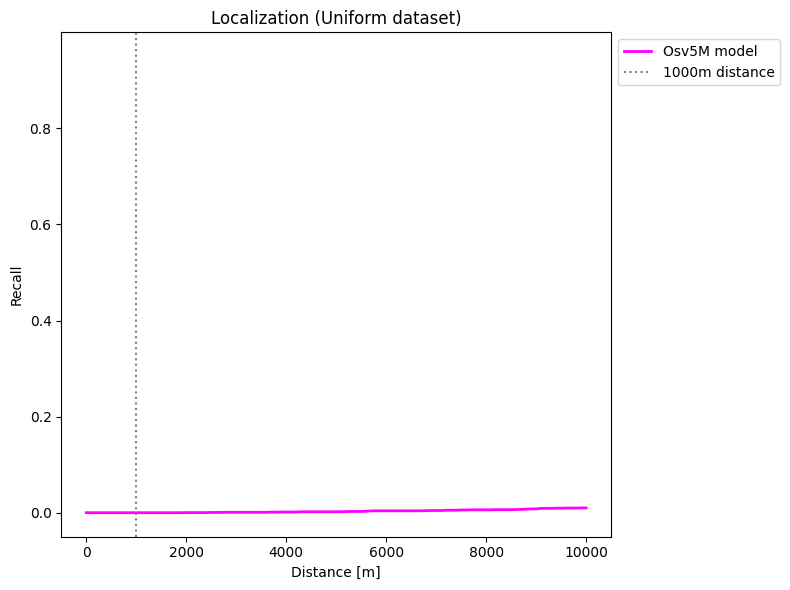

In [88]:
plot_recall_curve(dist_before)

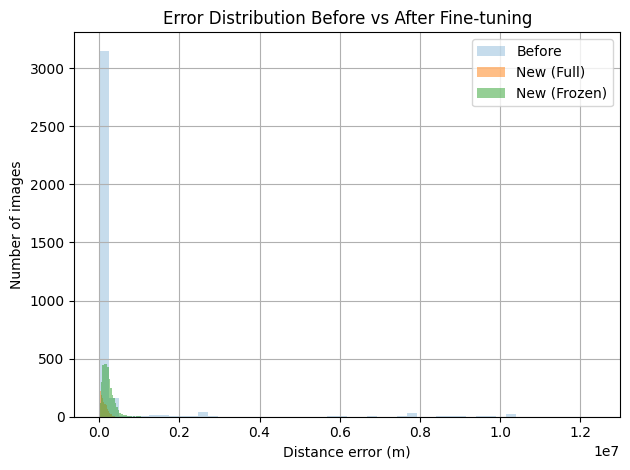

In [95]:
plt.hist(dist_before, bins=50, alpha=0.25, label='Before')
plt.hist(dist_new_full, bins=50, alpha=0.5, label='New (Full)')
plt.hist(dist_new_frozen, bins=50, alpha=0.5, label='New (Frozen)')
plt.xlabel('Distance error (m)')
plt.ylabel('Number of images')
plt.legend()
plt.title('Error Distribution Before vs After Fine-tuning')
plt.grid(True)
plt.tight_layout()
plt.show()


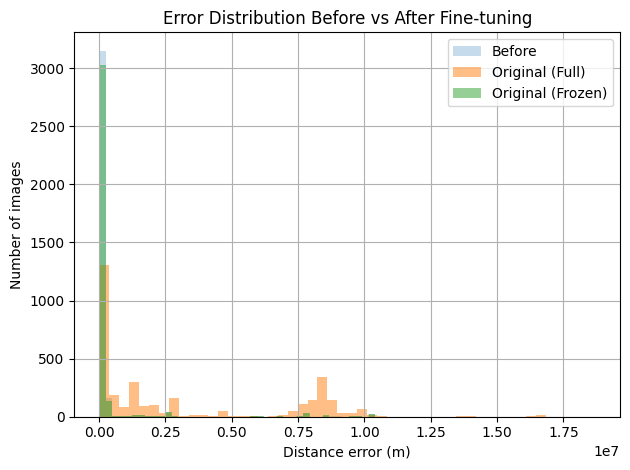

In [96]:
plt.hist(dist_before, bins=50, alpha=0.25, label='Before')
plt.hist(dist_original_full, bins=50, alpha=0.5, label='Original (Full)')
plt.hist(dist_original_frozen, bins=50, alpha=0.5, label='Original (Frozen)')
plt.xlabel('Distance error (m)')
plt.ylabel('Number of images')
plt.legend()
plt.title('Error Distribution Before vs After Fine-tuning')
plt.grid(True)
plt.tight_layout()
plt.show()

In [61]:
def plot(train_loss, val_loss):
    epochs = list(range(1, len(train_loss) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (radians)')
    plt.title('Training vs Validation Loss (Frozen)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [62]:
# New head frozen regression
train_loss = [0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
val_loss = [0.02, 0.02, 0.04, 0.02, 0.03, 0.03, 0.02, 0.03, 0.03, 0.02]

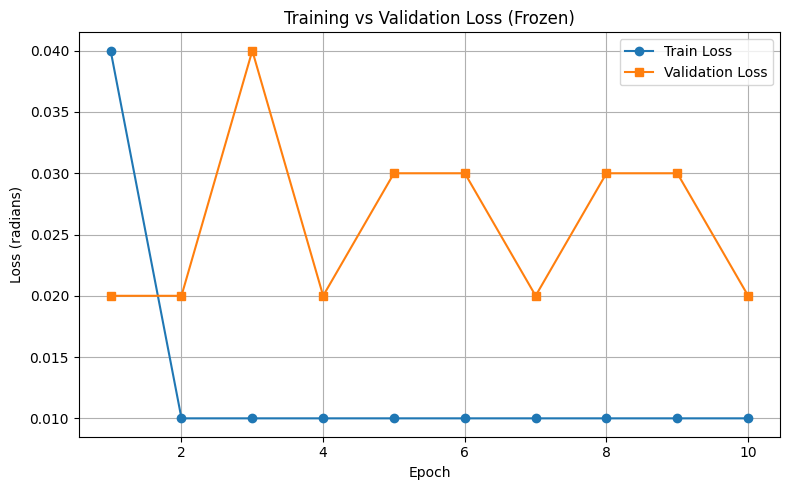

In [63]:
plot(train_loss, val_loss)

In [64]:
# New head regression frozen
train_loss = [0.12, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02]
val_loss = [0.06, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03]

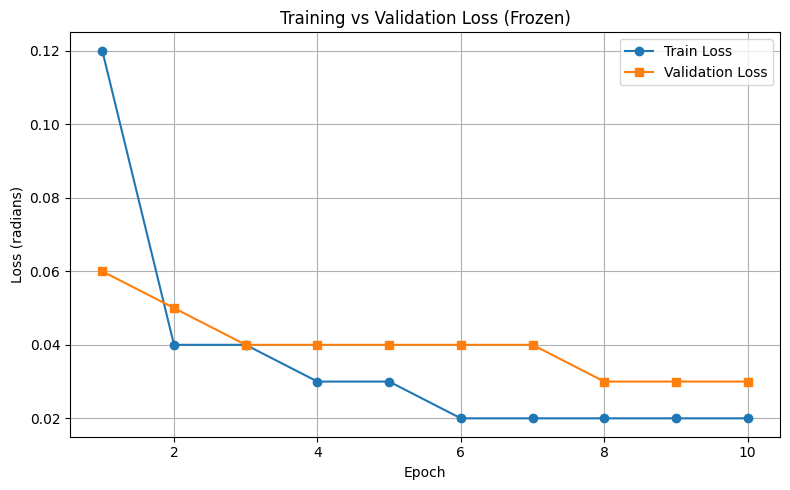

In [65]:
plot(train_loss, val_loss)

In [67]:
# Old head regression full
train_loss = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
val_loss = [0.28, 0.18, 0.31, 0.18, 0.37, 0.28, 0.26, 0.34, 0.25, 0.32]

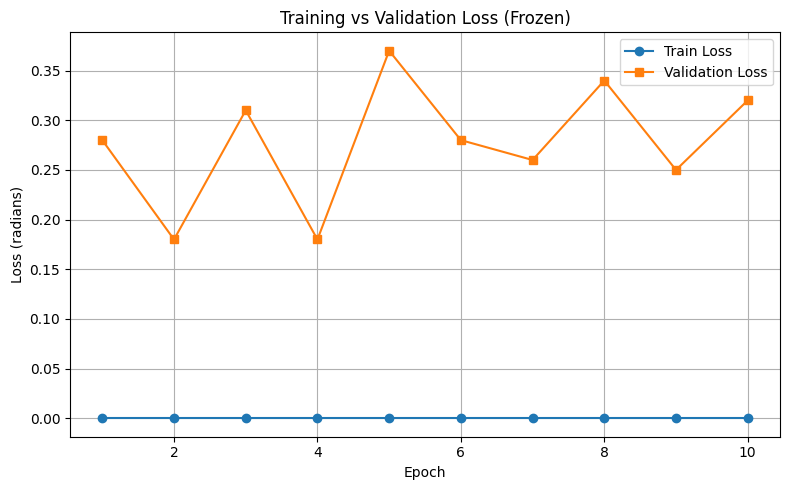

In [68]:
plot(train_loss, val_loss)

In [69]:
# Old head regression frozen
train_loss = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
val_loss = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

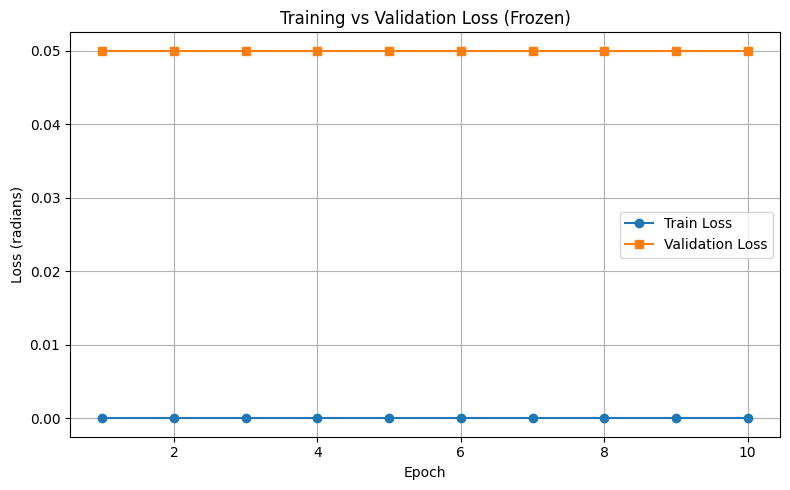

In [70]:
plot(train_loss, val_loss)